In [1]:
import numpy as np
import pandas as pd
import datetime


df_heat = pd.read_csv('/Users/kuznetsovnikita/recommendations/data/raw/heats.csv', sep = ',', converters={'product_id':str,'ym_client_id':str})
# df_heat['ym_client_id'] = df_heat['ym_client_id'].astype(str)
cart = pd.read_csv('/Users/kuznetsovnikita/recommendations//data/raw/cart.csv',sep = ',',converters={'product_id':str})
users = pd.read_csv('/Users/kuznetsovnikita/recommendations/data/raw/users.csv')
vygruz = pd.read_excel('/Users/kuznetsovnikita/recommendations/data/raw/goods.xlsx')
# sep=',',converters={'id':str})


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
pd.set_option('display.max_columns',100)

In [3]:
# процент активных пользователей
act_users = users.loc[users.check_week == 'Заходил в течении недели'].shape[0]/users.shape[0]
act_users

0.1816860465116279

In [16]:
cart['product_id'] = cart['product_id'].replace('',np.nan,regex= False).astype(float)
vygruz.cumdate = pd.to_datetime(vygruz.cumdate, infer_datetime_format=True)
vygruz.loc[:,['days_in_stock']] = (datetime.datetime.now()-vygruz.cumdate).dt.days
vygruz.loc[:,['discount']] =np.where(vygruz['Цена со скидкой'].isna(), 0,(vygruz['Цена шоурум']-vygruz['Цена со скидкой'])/vygruz['Цена шоурум'])
vygruz = vygruz.loc[vygruz.id != '']
# vygruz.id = vygruz.id.replace(' ','',regex=True)

vygruz = vygruz.loc[~vygruz.id.isnull()]
vygruz = vygruz[vygruz['id'].str.isnumeric()]
# print(vygruz.info())
vygruz['id'] = vygruz.id.replace('',np.nan, regex=False).astype(int)

# vygruz.loc[~vygruz['Цена со скидкой'].isna()].loc[:,['Цена со скидкой','Цена шоурум','discount']]

In [18]:
## потоварная статистика
df_heat['product_id'] = df_heat['product_id'].str.rstrip('.0')
products = df_heat.loc[(~(df_heat.product_id.isin(['0',''])))&(df_heat.product_id != '16777215')] #выкидываю технические неполадки
# products = products.loc[(products['product_id'].apply(type) == int)] 
rating = products.groupby(['product_id'])['_id'].count().reset_index().sort_values('_id', ascending=False)

rating

,product_id,_id
2923,2000000101712,1989
1690,2000000073774,823
648,2000000038773,586
3336,2000000107073,571
2051,2000000082837,556
...,...,...
2523,2000000094144,1
2522,2000000094137,1
2521,2000000094021,1
2518,2000000093802,1


In [20]:
vygruz.loc[:,['id_s']] = vygruz.id.astype(str)

<AxesSubplot:xlabel='categ'>

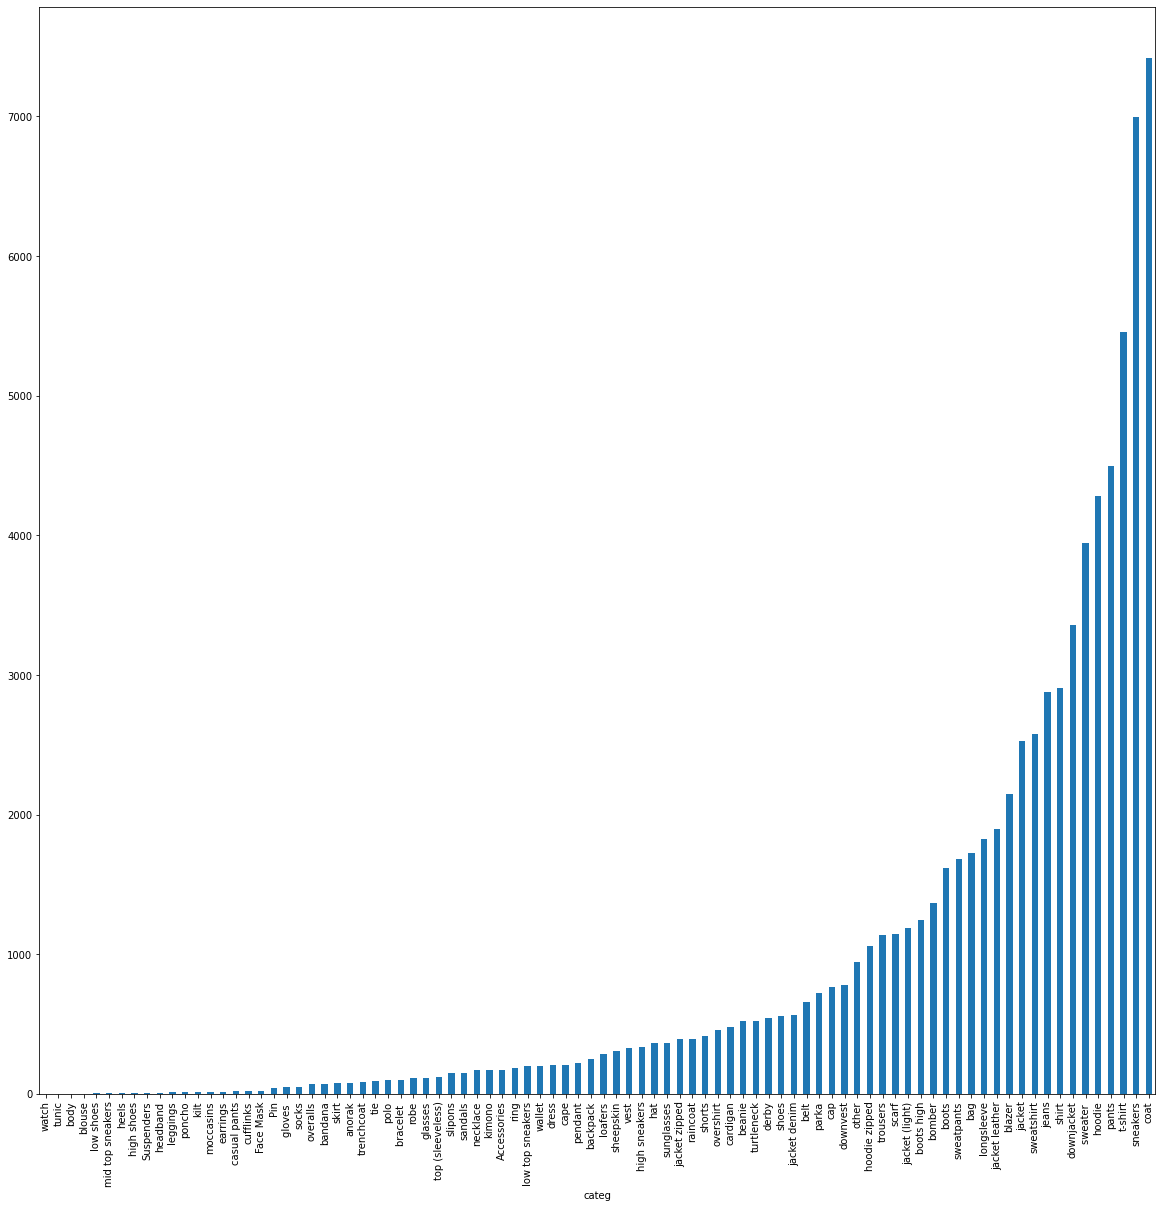

In [21]:
# добавляю всю информацию по каждой вещи
rating_full = rating.merge(vygruz, how = 'left', left_on='product_id', right_on='id_s')
# график с просмотрам по каждой категории товаров
rating_full.loc[:,['_id','categ']].groupby('categ')['_id'].sum().sort_values().plot(kind = 'bar', figsize = (20,20))

In [21]:
rating.merge(vygruz, how='left', left_on='product_id', 
             right_on='id_s').loc[:,['id','_id','days_in_stock','Цена шоурум','discount','categ','cond']].to_csv('rating_for_lm.csv')

In [22]:
cart.product_id.dropna().sort_values()

1193    2.000000e+12
2033    2.000000e+12
1264    2.000000e+12
681     2.000000e+12
1367    2.000000e+12
            ...     
485     2.000000e+12
1476    2.000000e+12
1015    2.000000e+12
1021    2.000000e+12
510     2.000000e+12
Name: product_id, Length: 2051, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:xlabel='categ'>

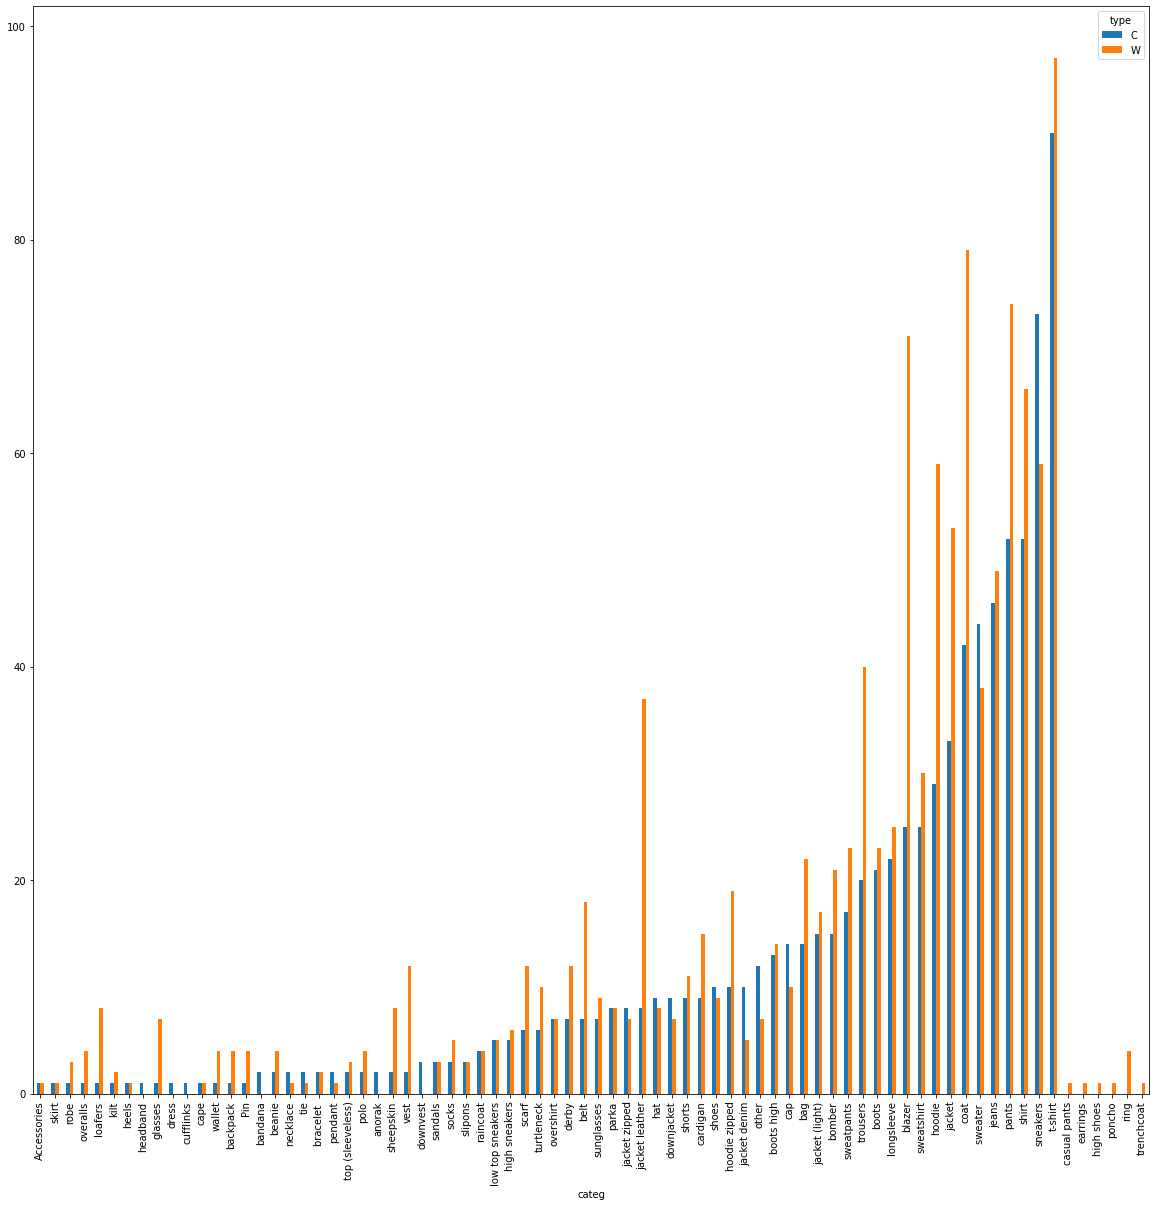

In [28]:
# теперь аналогично посмотрим на добавления в корзину/вишлисты
vygruz['id'] = vygruz.id.replace('',np.nan, regex=False).astype(int)
cart = cart.dropna(subset = ['product_id'])
cart.loc[:,['product_id']] = cart.product_id.astype(int)

cart_full = cart.merge(vygruz.loc[:,['id','categ']], how='left', left_on='product_id', right_on='id')

cart_full_gb = cart_full.groupby(['type','categ'])['id'].count().reset_index()
cart_full_piv = cart_full_gb.sort_values(['type','id'], 
                                         ascending=[True, False]).pivot(columns = ['type'], 
                                                                        index = 'categ',
                                                                        values = 'id')
# сменить на барплоты!

cart_full_piv.sort_values('C').plot(kind = 'bar',subplots = False, layout = (2,1), figsize = (20,20), legend = True)


In [29]:
# достаю списки товаров из корзин/вишлистов/заказов каждого клиента
cart_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'W')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
wish_user_prod = cart.loc[(~cart.ym_client_id.isin([None,0,'','0','null']))
                          &(cart.type == 'C')].groupby('ym_client_id')['product_id'].apply(list).to_frame()
# засовываю в единый фрейм с учетом непересечений
cart_wish_user_prod = cart_user_prod.join(wish_user_prod, 
                                          how = 'outer', 
                                          on ='ym_client_id', 
                                          lsuffix = '_cart', 
                                          rsuffix = '_wish').drop_duplicates('ym_client_id').reset_index().drop(columns = 'index')
cart_wish_user_prod
# wish_user_prod

,ym_client_id,product_id_cart,product_id_wish
0,1586517765142996502,"[2000000079578, 2000000071244]",[2000000109862]
1,15945421401032860445,[2000000103075],NaN
2,1594795295110685242,"[2000000071398, 2000000087337, 2000000089102, ...",[2000000113975]
3,15958550101040682370,[2000000077543],"[2000000077482, 2000000039305, 2000000076768, ..."
4,15994293991042599838,"[2000000085289, 2000000113500, 2000000072203]",NaN
...,...,...,...
466,1640025326513870565,NaN,[2000000076294]
467,1640029182550041790,NaN,[2000000064703]
468,1640037732927270538,NaN,[2000000082677]
469,1640037769919367583,NaN,[2000000121505]


In [122]:
cart.product_id.astype(str)

0       2000000049984
1       2000000084626
2       2000000026770
3       2000000097541
4       2000000106342
            ...      
2052    2000000018447
2053    2000000046327
2054    2000000018416
2055    2000000091587
2056    2000000090177
Name: product_id, Length: 2051, dtype: object

In [120]:
# создаю матрицу предпочтений по трем видам (пока что) оценок: просмотр товара, добавление в корзину/вишлист, добавление в заказ
products['ym_client_id'] = products['ym_client_id'].astype(str)
products = products.loc[products.product_id != 'NaN']

# делаю список со всеми возможными вещами, обрезать по наличию буду потом
all_items = np.unique(np.concatenate([products.product_id,cart.product_id.astype(str)]))
product_id_cols = [str(i) for i in all_items]
product_id_cols.extend(['product_id_wish','product_id_cart','product_id', 'ym_client_id'])
product_id_cols.reverse()

In [51]:
user_product_heat = products.groupby('ym_client_id')['product_id'].apply(list).reset_index()
user_product_heat = user_product_heat.merge(cart_wish_user_prod, how ='outer', on = 'ym_client_id')
user_product_heat = user_product_heat.reindex(columns=product_id_cols, fill_value=0).set_index('ym_client_id')
user_product_heat = user_product_heat.loc[:,~user_product_heat.columns.duplicated()]
user_product_heat.fillna({'product_id':'', 'product_id_cart':'', 'product_id_wish':''}, inplace=True)
user_product_heat

,product_id,product_id_cart,product_id_wish,4294967295,2000000121796,2000000121789,2000000121772,2000000121765,2000000121741,2000000121727,200000012171,2000000121635,2000000121581,200000012155,2000000121543,2000000121536,2000000121512,2000000121505,2000000121499,2000000121482,2000000121475,2000000121444,2000000121437,200000012142,2000000121413,2000000121406,200000012139,2000000121376,2000000121369,2000000121345,2000000121338,2000000121321,2000000121239,2000000121208,2000000121161,2000000121154,2000000121147,200000012113,2000000121123,2000000121116,2000000121093,2000000121086,2000000121079,2000000121062,2000000121055,2000000121031,2000000121017,2000000120935,2000000120898,2000000120874,...,200000000303,2000000002972,2000000002729,2000000002712,2000000002699,2000000002675,2000000002606,2000000002583,2000000002569,2000000002385,2000000002378,2000000002323,2000000002279,2000000002262,2000000002248,2000000002224,2000000002002,2000000001982,2000000001951,2000000001906,2000000001845,2000000001838,2000000001692,2000000001661,2000000001616,2000000001609,2000000001593,2000000001562,2000000001456,2000000001357,2000000001265,2000000001258,2000000001203,200000000118,2000000001142,2000000000657,2000000000626,2000000000589,2000000000558,2000000000541,2000000000411,2000000000374,2000000000367,2000000000299,2000000000220,200000000022,2000000000213,2000000000169,2000000000138,2000000000046
ym_client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1586517765142996502,"[2000000107585, 2000000101712, 2000000003528, ...","[2000000079578, 2000000071244]",[2000000109862],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1586839436824718143,"[2000000009889, 2000000109282, 2000000089591]",,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1586861088574635654,"[2000000080772, 2000000114279, 2000000007397, ...",,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1586877094630823534,"[2000000078847, 2000000089768, 2000000089768, ...",,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1587480513689496288,"[2000000062983, 2000000107592, 2000000062983]",,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639340203201076568,,,"[2000000109459, 2000000118437]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1639349253167263050,,,[2000000110608],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1639646255164570898,,,[2000000118512],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [66]:


# заполняю матрицу предпочтений ранжированными значениями (!!запихнуть в функцию потом!!)
for i in range(user_product_heat.shape[0]):
    if type(user_product_heat.loc[:,'product_id'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id'].iat[i]:
            user_product_heat[f'{product}'].iat[i] += 1
    if type(user_product_heat.loc[:,'product_id_cart'].iat[i]) == list:
        for product in user_product_heat.loc[:,'product_id_cart'].iat[i]:
            
            user_product_heat[f'{product}'].iat[i] += 10
    if type(user_product_heat.loc[:,'product_id_wish'].iat[i])== list:
        for product in user_product_heat.loc[:,'product_id_wish'].iat[i]:
            user_product_heat[f'{product}'].iat[i] += 5

user_product_heat.drop(columns = ['product_id','product_id_cart','product_id_wish'], inplace = True)

#после этого, по сути, надо дропнуть вещи, которые уже архивные

user_product_heat

,4294967295,2000000121796,2000000121789,2000000121772,2000000121765,2000000121741,2000000121727,200000012171,2000000121635,2000000121581,200000012155,2000000121543,2000000121536,2000000121512,2000000121505,2000000121499,2000000121482,2000000121475,2000000121444,2000000121437,200000012142,2000000121413,2000000121406,200000012139,2000000121376,2000000121369,2000000121345,2000000121338,2000000121321,2000000121239,2000000121208,2000000121161,2000000121154,2000000121147,200000012113,2000000121123,2000000121116,2000000121093,2000000121086,2000000121079,2000000121062,2000000121055,2000000121031,2000000121017,2000000120935,2000000120898,2000000120874,2000000120812,2000000120805,2000000120768,...,200000000303,2000000002972,2000000002729,2000000002712,2000000002699,2000000002675,2000000002606,2000000002583,2000000002569,2000000002385,2000000002378,2000000002323,2000000002279,2000000002262,2000000002248,2000000002224,2000000002002,2000000001982,2000000001951,2000000001906,2000000001845,2000000001838,2000000001692,2000000001661,2000000001616,2000000001609,2000000001593,2000000001562,2000000001456,2000000001357,2000000001265,2000000001258,2000000001203,200000000118,2000000001142,2000000000657,2000000000626,2000000000589,2000000000558,2000000000541,2000000000411,2000000000374,2000000000367,2000000000299,2000000000220,200000000022,2000000000213,2000000000169,2000000000138,2000000000046
ym_client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1586517765142996502,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1586839436824718143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1586861088574635654,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1586877094630823534,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1587480513689496288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639340203201076568,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1639349253167263050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1639646255164570898,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
user_product_heat.values.mean()

0.00072075596873755

In [85]:

combinations = {
#     1:['categ'],
#     2:['brand'],
#     3:['categ','brand'],
    4:['brand','Группа категорий']
}



In [111]:
dict_combs = {}
for num, comb in combinations.items():
    cols = ['id_s']
    cols.extend(comb)
    brand_categ = user_product_heat.T.merge(vygruz.loc[:,cols], how='left',left_on = user_product_heat.T.index,right_on='id_s')
    stock = vygruz.loc[vygruz.reason == 'Приемка'].groupby(comb)['id_s'].count()
    
    dict_combs[num] = brand_categ.groupby(comb).sum()
    dict_combs[num] = dict_combs[num].join(stock)
    dict_combs[num] = dict_combs[num].loc[~((dict_combs[num].id_s.isna())|(dict_combs[num].id_s ==1))]
    
    dict_combs[num].loc['user_total'] = dict_combs[num].drop(columns = ['id_s']).sum(axis=0)
    dict_combs[num].loc[:,['item_total']] = dict_combs[num].drop(columns = ['id_s']).sum(axis=1)
#     dict_combs[tuple(comb)].append(dict_combs[tuple(comb)].sum(numeric_only=True), ignore_index=True)


In [112]:
dict_combs[4]

,1586517765142996502,1586839436824718143,1586861088574635654,1586877094630823534,1587480513689496288,1587732076104489525,1587819907779396547,1588086459474901285,1588086482831295602,1588086803767309648,1589202270114292505,1589209329103247949,1589483252238892978,1589814163692204943,1590176421622779706,1590253064380031509,1590659511507898718,1591284322559771176,1591370843897353895,15913860601003544332,1591701810230119000,1591807338317190145,1591872826315189699,1591938765443742802,1592032922183643801,159224830943409887,1592408871197543050,15924155231036596763,1592694669483395654,1592731189549513351,1592847484780941724,1592861207492238291,1592929721329237660,1592946946186677299,1592953154652223350,1593090856242451567,1593100000370479267,1593115948619732803,1593201376296103831,1593376043656329764,1593443482854562477,1593771361609025167,15942383401053570880,1594394573856883792,1594414364538150865,1594440265824202191,1594477946571480586,15945421401032860445,1594674543340830487,1594742086880629311,...,16395787941037831654,1633532017660392414,163358592060180374,16340476031007959156,1634575475990178488,1635060091465007024,1635066652789734593,1635110108437038147,1635152180849836368,1635187495438307929,1635239758387107583,1635322233415278144,1635330062271261100,1635696058255641216,1636163068984203323,1636270534728110515,1636633848855834481,1636831744489564480,1636982316555187308,1637082694702334413,163708966547832707,1637756723515253358,1637850858397846413,1637907591361801618,163795024949167449,1638098400155449361,1638106357281174789,1638301422383737367,16385264491032120507,1638658290651972380,1638670467399942284,1638722806536738744,1638752872375211341,163881840994012757,163882267193195774,1638885802716442867,1638990566671335222,1639156760295708181,1639201509923529395,1639247577623015204,163933435119315500,1639338939838372129,1639340042428973260,1639340203201076568,1639349253167263050,1639646255164570898,1639859084928947776,1640068040592070641,id_s,item_total
"(1017 ALYX 9SM, Футболки и лонгсливы)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,38.0
"(10sei0otto, Джемперы и свитеры)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(11 By Boris Bidjan Saberi, Футболки и лонгсливы)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0
"(11 By Boris Bidjan Saberi, Штаны и брюки)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,62.0
"(424 On Fairfax, Куртки и пуховики)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [110]:
dict_combs[4].columns

Index(['1586517765142996502', '1586839436824718143', '1586861088574635654',
       '1586877094630823534', '1587480513689496288', '1587732076104489525',
       '1587819907779396547', '1588086459474901285', '1588086482831295602',
       '1588086803767309648',
       ...
       '163933435119315500', '1639338939838372129', '1639340042428973260',
       '1639340203201076568', '1639349253167263050', '1639646255164570898',
       '1639859084928947776', '1640068040592070641', 'id_s',
       '('brand', 'Группа категорий')_total'],
      dtype='object', length=27635)

In [113]:
dict_combs[4].drop(columns = ['id_s','item_total']).sum(axis=0)

1586517765142996502    62.0
1586839436824718143     6.0
1586861088574635654     4.0
1586877094630823534    10.0
1587480513689496288     4.0
                       ... 
1639340203201076568    10.0
1639349253167263050    10.0
1639646255164570898    10.0
1639859084928947776    10.0
1640068040592070641    10.0
Length: 27633, dtype: float64

In [116]:
dict_combs[4].drop(columns = ['id_s','item_total'], index = ['user_total']).values.mean()

0.0039580972286550305

веса сделать параметром
три таблицы: 
1) по строчкам юзеры, по столбцам инфа по ним (даты визитов, число просмотров и тд)
2) то же самое по группам бренд-группа категорий (сколько товаров, сколько просмотров, когда)
3) сама матрица юзер-айтем
4) распределение клиент - устройство
5) сделать py файлы которые берут инфу из монги и обрабатывают ее в таблички 1)-3), эти файлы лежат в src 

In [123]:
# ready table one
# по строчкам юзеры, по столбцам инфа по ним (даты визитов, число просмотров и тд)
users_info = pd.DataFrame()
users_info.index = df_heat.ym_client_id.unique()

# всего переходов по страницам
users_info['views'] = df_heat.groupby('ym_client_id').agg({'_id':'count'})
#список просмотренных товаров
users_info['products'] = df_heat.loc[~df_heat.product_id.isin([0,'0',''])].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['list']
#кол-во просмотренных товаров (возможны повторные просмотры тех же товаров)
users_info['products_quan'] = df_heat.loc[~df_heat.product_id.isin([0,'0',''])].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['count']
#добавления в корзину
users_info['carts'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='C')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['list']
#кол-во добавлений в корзину
users_info['carts_quan'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='C')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['count']

#добавления в вишлист
users_info['wish'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='W')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['list']
#кол-во добавлений в вишлист
users_info['wish_quan'] = cart_full.loc[(~cart_full.ym_client_id.isin(['null','','0']))&(cart_full.type=='W')
             ].groupby('ym_client_id').agg({'product_id':[list,'count']})['product_id']['count']

users_info
# .loc[users_info.carts_quan>0].sort_values('views')




,views,products,products_quan,carts,carts_quan,wish,wish_quan
1634376464775853163,85,"[2000000084909, 200000008451, 2000000073705, 2...",53.0,NaN,NaN,NaN,NaN
16177636401065163291,188,"[2000000076294, 2000000051208, 2000000011011, ...",77.0,NaN,NaN,NaN,NaN
1630659159952734277,252,"[2000000107752, 2000000095073, 2000000104294, ...",41.0,NaN,NaN,NaN,NaN
1630833206792953159,458,"[2000000094601, 2000000108322, 2000000109251, ...",55.0,NaN,NaN,NaN,NaN
163386231741398227,123,"[2000000082929, 200000007531, 2000000061689, 2...",35.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1640084780493319261,1,NaN,NaN,NaN,NaN,NaN,NaN
1640085005597855828,1,[2000000038773],1.0,NaN,NaN,NaN,NaN
1640085155553504346,3,NaN,NaN,NaN,NaN,NaN,NaN
1640085294981803057,1,[200000010331],1.0,NaN,NaN,NaN,NaN


In [38]:
users_info.loc[users_info.wish_quan>0]

,views,products,products_quan,carts,carts_quan,wish,wish_quan
1630833206792953159,413,"[2000000094601, 2000000108322, 2000000109251, ...",46.0,NaN,NaN,[2000000104775],1.0
1634332198261008216,41,"[2000000101712, 2000000107707, 2000000107707, ...",17.0,NaN,NaN,"[2000000000299, 2000000064789, 2000000107707, ...",5.0
162721092532695845,304,"[2000000072418, 2000000072418, 2000000072425, ...",47.0,"[2000000066998, 2000000073354]",2.0,"[2000000039251, 2000000040868, 2000000038278, ...",16.0
1632300479943213942,289,"[2000000093383, 2000000018386, 2000000058443, ...",46.0,"[2000000090252, 2000000093383, 2000000095073, ...",5.0,"[2000000108728, 2000000038742, 2000000115351]",3.0
1633957867872449082,98,"[2000000090139, 2000000040059, 2000000107653, ...",30.0,[2000000105994],1.0,"[2000000049885, 2000000107653, 2000000090139]",3.0
...,...,...,...,...,...,...,...
1639244204412542966,69,"[2000000107196, 2000000107233, 2000000091587, ...",25.0,[2000000114620],1.0,"[2000000107233, 2000000060156, 2000000012544, ...",10.0
16204195481043631860,11,NaN,NaN,[2000000071077],1.0,"[2000000077987, 2000000072364, 2000000062327, ...",11.0
1639292206509479425,31,"[2000000107073, 2000000114842, 20000001166, 20...",12.0,NaN,NaN,[2000000116242],1.0
1639328016711046839,29,"[2000000101712, 200000007627, 2000000078328, 2...",14.0,NaN,NaN,[2000000104270],1.0


In [124]:
# ready table two 
# то же самое по группам бренд-группа категорий (сколько товаров, сколько просмотров, когда)
brand_categ_info = vygruz.loc[vygruz.reason =='Приемка'].groupby(['brand',
                                                                  'Группа категорий']).agg({'id':'count','id_s':list})
# .loc[vygruz.id_s.isin(df_heat.product_id.unique())] # для включения только тех групп, что просмотрены
brand_categ_info = brand_categ_info.loc[brand_categ_info.id > 0].sort_values('id', ascending = False)
# суммарные просмотры всех вещей из категории+бренда
brand_categ_info['total_views'] = brand_categ_info['id_s'].apply(lambda x: 
                                                                 df_heat.loc[df_heat.product_id.isin(x)]['_id'].count())
# среднее число просмотров одной вещи
brand_categ_info['mean_views'] = round(brand_categ_info['total_views'] / brand_categ_info['id'],2)
# список времен просмотров (можно сделать еще доп. столбец с относительной новизной)
brand_categ_info['view_times'] = brand_categ_info['id_s'].apply(lambda x: 
                                                                df_heat.loc[df_heat.product_id.isin(x)]['timestamp'].to_list())



brand_categ_info

id  \
brand                   Группа категорий           
Haider Ackermann        Штаны и брюки         37   
Nike                    Кроссовки и кеды      30   
Saint Michael           Свитшоты и худи       27   
Saint Laurent Paris     Пальто и плащи        20   
Enfants Riches Deprimes Футболки и лонгсливы  20   
...                                           ..   
Isabel Benenato         Пальто и плащи         1   
                        Пиджаки и жилеты       1   
Issey Miyake            Пиджаки и жилеты       1   
                        Рубашки                1   
Рассвет                 Футболки и лонгсливы   1   

                                                                                           id_s  \
brand                   Группа категорий                                                          
Haider Ackermann        Штаны и брюки         [2000000018522, 2000000026091, 2000000031286, ...   
Nike                    Кроссовки и кеды      [2000000028293, 2000000061771, 2000000066202, ...   
Saint Michael           Свитшоты и худи       [2000000085739, 2000000088556, 2000000088648, ...   
Saint Laurent Paris     Пальто и плащи        [2000000015668, 2000000017952, 2000000018256, ...   
Enfants Riches Deprimes Футболки и лонгсливы  [2000000016009, 2000000016016, 2000000016023, ...   
...                                                                                         ...   
Isabel Benenato         Пальто и плащи                                          [2000000054094]   
                        Пиджаки и жилеты                                        [2000000102757]   
Issey Miyake            Пиджаки и жилеты                                        [2000000106731]   
                        Рубашки                                                 [2000000032375]   
Рассвет                 Футболки и лонгсливы                                    [2000000118239]   

                                              total_views  mean_views  \
brand                   Группа категорий                                
Haider Ackermann        Штаны и брюки                 546       14.76   
Nike                    Кроссовки и кеды              870       29.00   
Saint Michael           Свитшоты и худи               151        5.59   
Saint Laurent Paris     Пальто и плащи                545       27.25   
Enfants Riches Deprimes Футболки и лонгсливы          149        7.45   
...                                                   ...         ...   
Isabel Benenato         Пальто и плащи                 35       35.00   
                        Пиджаки и жилеты               11       11.00   
Issey Miyake            Пиджаки и жилеты               40       40.00   
                        Рубашки                        26       26.00   
Рассвет                 Футболки и лонгсливы            0        0.00   

                                                                                     view_times  
brand                   Группа категорий                                                         
Haider Ackermann        Штаны и брюки         [2021-10-18 17:34:52, 2021-10-20 18:27:40, 202...  
Nike                    Кроссовки и кеды      [2021-10-16 13:27:19, 2021-10-16 17:30:49, 202...  
Saint Michael           Свитшоты и худи       [2021-11-03 20:31:18, 2021-11-04 15:07:29, 202...  
Saint Laurent Paris     Пальто и плащи        [2021-10-16 12:44:05, 2021-10-16 14:24:08, 202...  
Enfants Riches Deprimes Футболки и лонгсливы  [2021-10-16 16:49:08, 2021-10-21 05:30:34, 202...  
...                                                                                         ...  
Isabel Benenato         Пальто и плащи        [2021-10-17 23:02:49, 2021-10-20 23:27:50, 202...  
                        Пиджаки и жилеты      [2021-10-24 10:11:29, 2021-11-02 13:09:09, 202...  
Issey Miyake            Пиджаки и жилеты      [2021-10-17 15:33:40, 2021-10-17 22:51:29, 202...  
                        Рубашки               [2021-1

<AxesSubplot:ylabel='Frequency'>

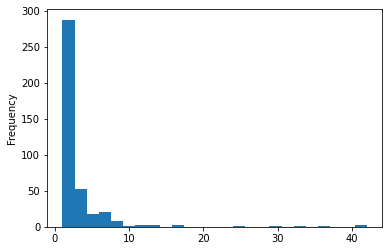

In [10]:
user_client_df = df_heat.loc[df_heat.user_id != 0].groupby(['user_id','ym_client_id']).count().reset_index()
user_client_df.drop(columns = ['_id','current_url','product_id','timestamp'], inplace=True)
user_client_df = user_client_df.join(user_client_df.groupby('user_id')['ym_client_id'].transform('count'), rsuffix = '_count')
# user_client = user_client_df.to_dict()
user_client_df.set_index('user_id', inplace=True)
user_client_df.reset_index().drop_duplicates('user_id')['ym_client_id_count'].plot(kind = 'hist', bins = 25, xlabel ='кол-во client_id',ylabel = 'число user_id')

In [8]:
user_client_df.reset_index()

,user_id,ym_client_id,Unnamed: 0,ga_client_id,session_id,ip_address,ym_client_id_count
0,1,1586517765142996502,136,74,74,2,9
1,1,1591701810230119000,99,46,46,0,9
2,1,1614333203141223820,27,6,6,4,9
3,1,1615200562371260127,15,0,0,0,9
4,1,1620304476826610523,55,0,0,0,9
...,...,...,...,...,...,...,...
1120,12322,1644393939567835347,18,18,18,18,1
1121,12324,1639751347219747257,10,10,10,10,1
1122,12326,1616795693869896202,16,16,16,16,1
1123,12328,1644516025831911439,8,8,8,8,1


In [131]:
vygruz.columns

Index(['Unnamed: 0', 'id', 'status', 'reason', 'cumdate', 'selldate',
       'Дата выплаты', 'comit', 'Условия договора на товар ', 'Наименование',
       'Артикул', 'categ', 'Группа категорий', 'brand', 'Размер по бирке',
       'Размер', 'Состав', 'Категория рентабельности', 'cond', 'Сезон', 'Год',
       'Цвет', 'Есть фото?', 'Кол-во фото', 'Цена Grailed', 'Цена шоурум',
       'actprice', 'Закупочная цена', 'Цена со скидкой', 'Сравнительная цена',
       'sellprice', 'Сумма выплаты', 'Стоимость доставки', 'Комиссия платежки',
       'Комиссия площадки', 'Восстановление товарного вида',
       'Ссылки на все размещения через ;', 'ссылка на яндекс диск',
       'Имя клиента ', 'Платежная система', 'Площадка продажи',
       'код транзакции пп', 'Ответственный ', 'Отправитель', 'Трек-номер',
       'Статус доставки', 'В аренду? да/нет', 'Сколько стоит в аренду',
       'сколько раз было в аренде', 'сколько денег за аренду всего ',
       'Рассчет к выплате', 'storage', 'days_in_stock'